In [14]:
import sys
sys.path.append("..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import data_frame
import tensorflow as tf
import tensorflow_probability as tfp
import tf_keras
import models
from utils import load_config
from sklearn.preprocessing import StandardScaler

In [23]:
dataframes = []
for i in range(1,6):
    df = pd.read_csv(f"../../dataframes/experiment2.1/ANN_{i}.csv", index_col=0)
    df = df.loc[df["split"]=="test",["Z","Z_pred","faint"]]
    dataframes.append(df)

df = np.array(dataframes).reshape(-1,3)
df_test = df[df[:,2]==False][:,:2]
df_faint = df[df[:,2]==True][:,:2]

In [24]:
n_points = df_test.shape[0]
bins = np.arange(0,5,0.04)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
bin_width = bins[1] - bins[0]

hist_full, _ = np.histogram(df_test[:,1], bins=bins, density=True)

n_bootstrap = 1000
bootstrap_histograms = []

rng = np.random.default_rng(seed=1)
for _ in range(n_bootstrap):
    resampled = rng.choice(df_test[:,1], size=n_points, replace=True)
    hist, _ = np.histogram(resampled, bins=bins, density=True)
    bootstrap_histograms.append(hist)

bootstrap_histograms = np.array(bootstrap_histograms)

hist_mean = np.mean(bootstrap_histograms, axis=0)
hist_lower = np.percentile(bootstrap_histograms, 15.9, axis=0)
hist_upper = np.percentile(bootstrap_histograms, 84.1, axis=0)

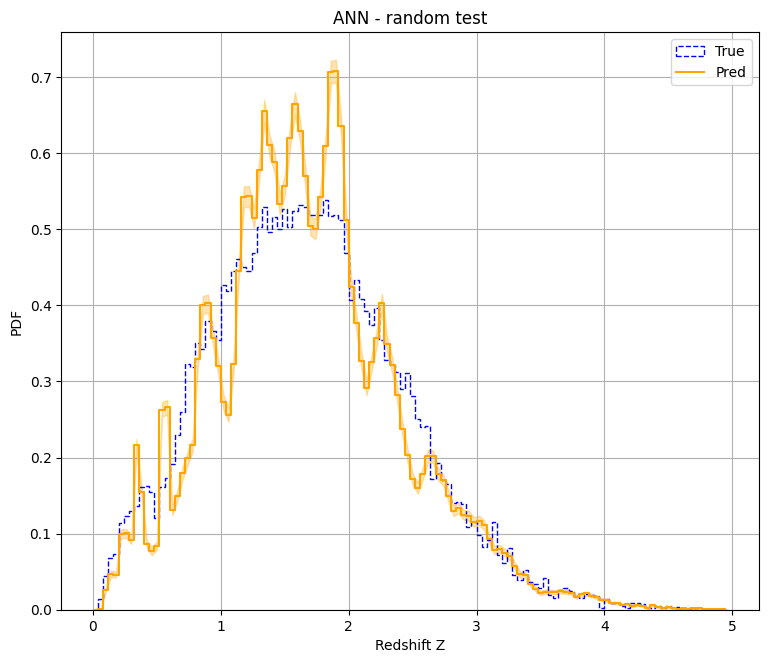

In [25]:
plt.figure(figsize=(9,7.5))
plt.hist(df_test[:,0], bins=np.arange(0,5,0.04), histtype="step", density=True, linestyle="--", color="blue", label="True")
plt.fill_between(bin_centers, hist_lower, hist_upper, color="orange", alpha=0.3)
plt.plot(bin_centers, hist_mean, drawstyle="steps-mid", color="orange", label="Pred")
plt.xlabel("Redshift Z")
plt.ylabel("PDF")
plt.legend()
plt.title("ANN - random test")
plt.grid(True)
plt.savefig("cool_pics/ANN_dist.png")
plt.show()

In [5]:
n_points = df_faint.shape[0]
bins = np.arange(0,5,0.04)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
bin_width = bins[1] - bins[0]

hist_full, _ = np.histogram(df_faint[:,1], bins=bins, density=True)

n_bootstrap = 1000
bootstrap_histograms = []

rng = np.random.default_rng(seed=1)
for _ in range(n_bootstrap):
    resampled = rng.choice(df_faint[:,1], size=n_points, replace=True)
    hist, _ = np.histogram(resampled, bins=bins, density=True)
    bootstrap_histograms.append(hist)

bootstrap_histograms = np.array(bootstrap_histograms)

hist_mean = np.mean(bootstrap_histograms, axis=0)
hist_lower = np.percentile(bootstrap_histograms, 15.9, axis=0)
hist_upper = np.percentile(bootstrap_histograms, 84.1, axis=0)

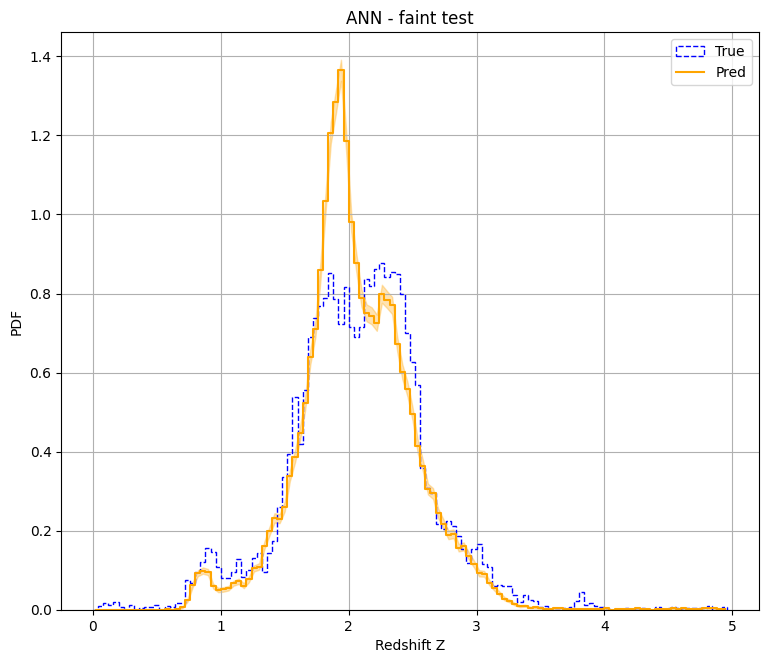

In [6]:
plt.figure(figsize=(9,7.5))
plt.hist(df_faint[:,0], bins=np.arange(0,5,0.04), histtype="step", density=True, linestyle="--", color="blue", label="True")
plt.fill_between(bin_centers, hist_lower, hist_upper, color="orange", alpha=0.3)
plt.plot(bin_centers, hist_mean, drawstyle="steps-mid", color="orange", label="Pred")
plt.xlabel("Redshift Z")
plt.ylabel("PDF")
plt.legend()
plt.title("ANN - faint test")
plt.grid(True)
plt.show()

In [18]:
filePath = "../../KiDS-DR5-WCScut_x_DESI-DR1-small.fits"

df = data_frame.DataFrame(filePath, "QSO", data_frame.MaxFiller())
X_train, y_train = df.get_train_dataset()
X_test, y_test = df.get_random_test_dataset()
X_faint, y_faint = df.get_faint_test_dataset()

scaler = StandardScaler()
scaler.fit(X_train)

X_test = scaler.transform(X_test)
X_faint = scaler.transform(X_faint)

In [19]:
hist_means = []
hist_lowers = []
hist_uppers = []
hist_stddevs = []

for n in range(1,6):
    config = {"num_components": n}
    
    all_models = []
    for i in range(1, 6):
        model_path = f"../../models/experiment2/MG_{config["num_components"]}_components_{i}/variables/variables"
        model = models.MLModelContext(strategy=models.MixtureGaussian(df, config)).strategy.network
        model.load_weights(model_path).expect_partial()
        all_models.append(model)

    distributions = []
    for model in all_models:
        distributions.append(model(X_test))
    
    n_samples = 1
    
    bins = np.arange(0, 5, 0.04)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    n_bootstrap = 1000
    bootstrap_histograms = []
    
    rng = np.random.default_rng(seed=1)
    
    for _ in range(n_bootstrap):
        samples = []
        for dist in distributions:
            samples.append(dist.sample(n_samples).numpy().reshape(-1,n_samples))
        samples = np.concatenate(samples)
        
        # resampled = rng.choice(samples, size=samples.shape[0], replace=True)
    
        hist, _ = np.histogram(samples.reshape(-1), bins=bins, density=True)
        bootstrap_histograms.append(hist)
    
    bootstrap_histograms = np.array(bootstrap_histograms)

    mean = np.mean(bootstrap_histograms, axis=0)
    std  = np.std(bootstrap_histograms, axis=0)
    
    hist_means.append(mean)
    hist_lowers.append(mean - std)
    hist_uppers.append(mean + std)
    hist_stddevs.append(std)
    
    # hist_means.append(np.mean(bootstrap_histograms, axis=0))
    # hist_lowers.append(np.percentile(bootstrap_histograms, 15.9, axis=0))
    # hist_uppers.append(np.percentile(bootstrap_histograms, 84.1, axis=0))
    # hist_stddevs.append(np.std(bootstrap_histograms, axis=0))

2025-08-12 10:16:33.844625: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


/tmp/ipykernel_255402/353881393.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.plot(0,0, color=None, label=f"Chi^2: {float(chi_sqr):.2f} ")


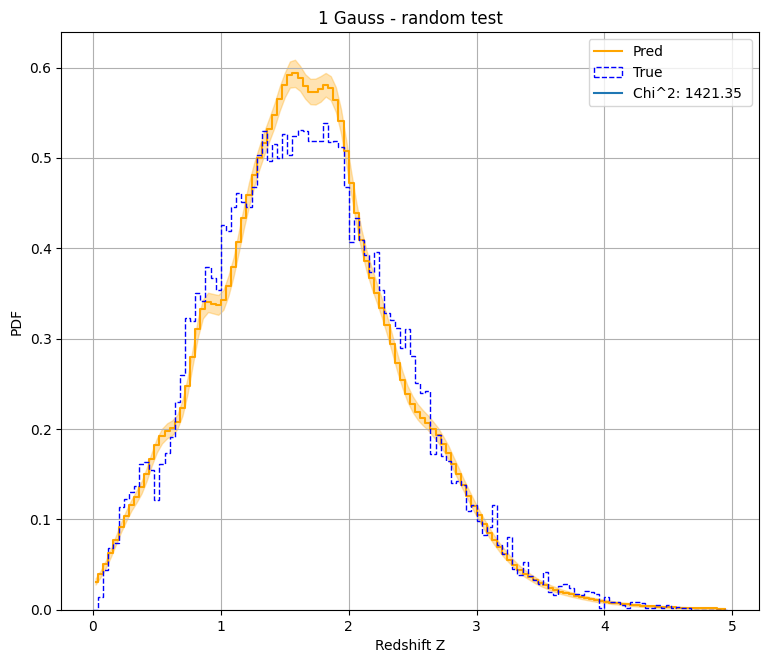

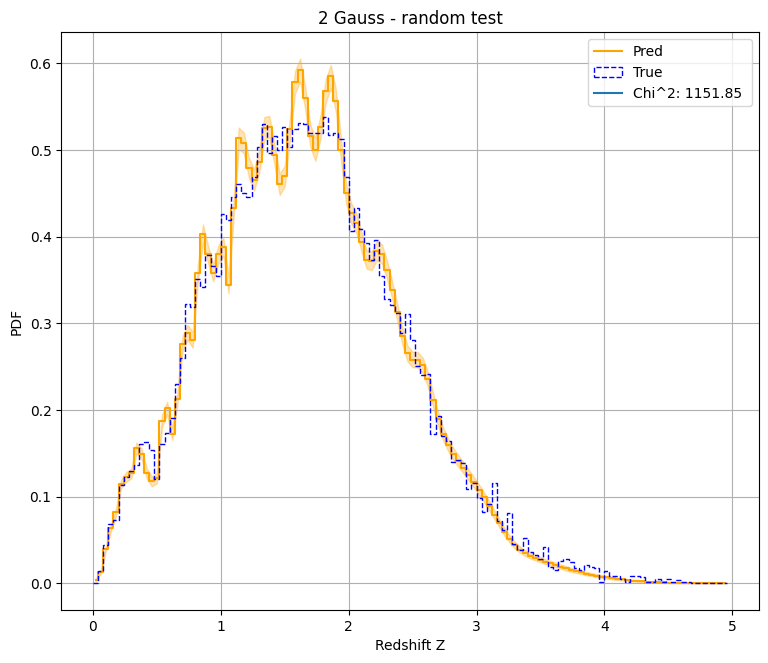

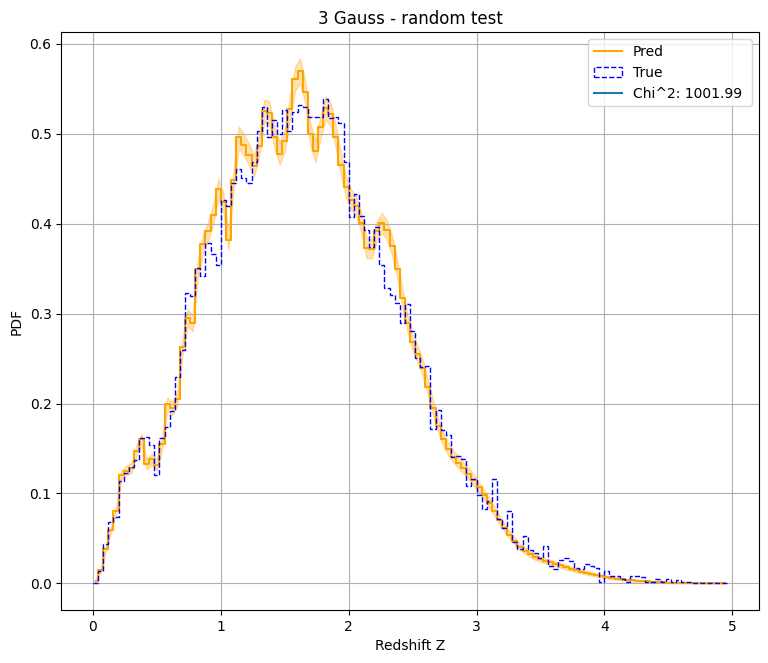

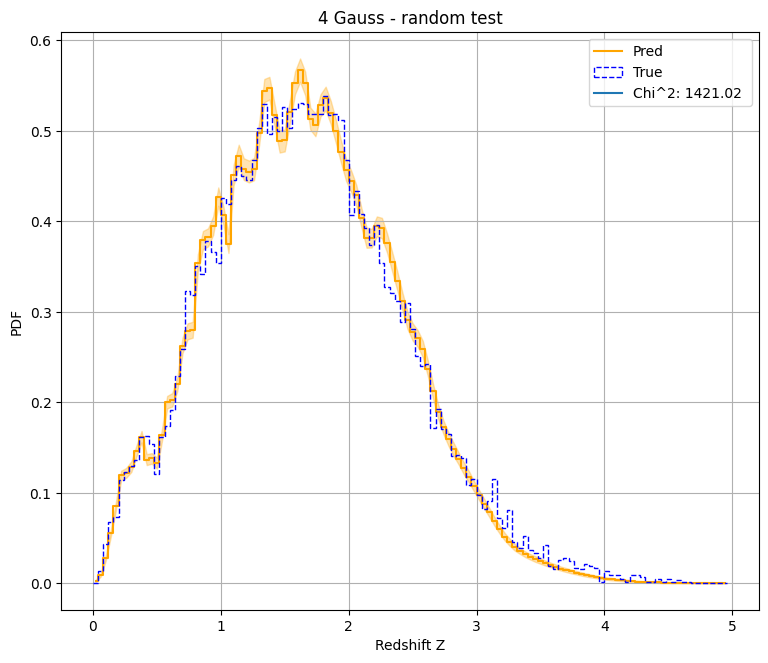

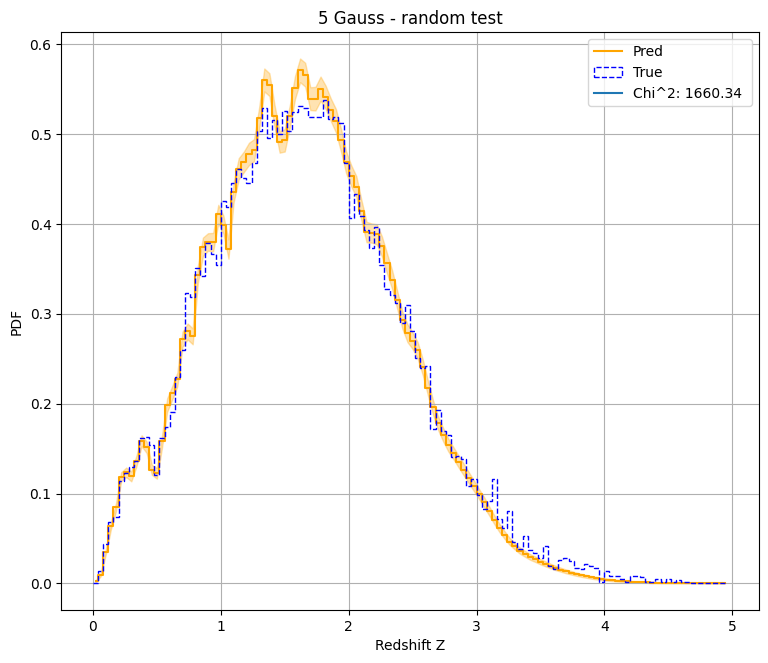

In [21]:
hist, _ = np.histogram(y_test, bins=bins, density=True)

i = 1
for hist_mean, hist_lower, hist_upper, hist_stddev in zip(hist_means, hist_lowers, hist_uppers, hist_stddevs):

    diff = (hist - hist_mean).reshape(-1,1)
    cov = np.diag(hist_stddev ** 2)
    cov_inv = np.linalg.inv(cov)
    chi_sqr = np.matmul(diff.T ,np.matmul(cov_inv, diff))
    
    plt.figure(figsize=(9,7.5))
    plt.plot(bin_centers, hist_mean, drawstyle='steps-mid',  color="orange", label=f'Pred')
    plt.fill_between(bin_centers, hist_lower, hist_upper, color="orange", alpha=0.3)
    plt.hist(y_test, bins=np.arange(0,5,0.04), histtype="step", density=True, color="blue", linestyle="--",label="True")
    plt.plot(0,0, color=None, label=f"Chi^2: {float(chi_sqr):.2f} ")
    plt.xlabel('Redshift Z')
    plt.ylabel('PDF')
    plt.title(f'{i} Gauss - random test')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"cool_pics/{i}_Gauss_dist.png")
    plt.show()

    i += 1

In [10]:
hist_means = []
hist_lowers = []
hist_uppers = []
hist_stddevs = []

for n in range(1,6):
    config = {"num_components": n}
    
    all_models = []
    for i in range(1, 6):
        model_path = f"../../models/experiment2/MG_{config["num_components"]}_components_{i}/variables/variables"
        model = models.MLModelContext(strategy=models.MixtureGaussian(df, config)).strategy.network
        model.load_weights(model_path).expect_partial()
        all_models.append(model)

    distributions = []
    for model in all_models:
        distributions.append(model(X_faint))
    
    n_samples = 1
    
    bins = np.arange(0, 5, 0.04)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    n_bootstrap = 1000
    bootstrap_histograms = []
    
    rng = np.random.default_rng(seed=1)
    
    for _ in range(n_bootstrap):
        samples = []
        for dist in distributions:
            samples.append(dist.sample(n_samples).numpy().reshape(-1,n_samples))
        samples = np.concatenate(samples)
        
        # resampled = rng.choice(samples, size=samples.shape[0], replace=True)
    
        hist, _ = np.histogram(samples.reshape(-1), bins=bins, density=True)
        bootstrap_histograms.append(hist)
    
    bootstrap_histograms = np.array(bootstrap_histograms)

    mean = np.mean(bootstrap_histograms, axis=0)
    std  = np.std(bootstrap_histograms, axis=0)
    
    hist_means.append(mean)
    hist_lowers.append(mean - std)
    hist_uppers.append(mean + std)
    hist_stddevs.append(std)
    
    # hist_means.append(np.mean(bootstrap_histograms, axis=0))
    # hist_lowers.append(np.percentile(bootstrap_histograms, 15.9, axis=0))
    # hist_uppers.append(np.percentile(bootstrap_histograms, 84.1, axis=0))
    # hist_stddevs.append(np.std(bootstrap_histograms, axis=0))

/tmp/ipykernel_248325/2109989616.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.plot(0,0, color=None, label=f"Chi^2: {float(chi_sqr):.2f} ")


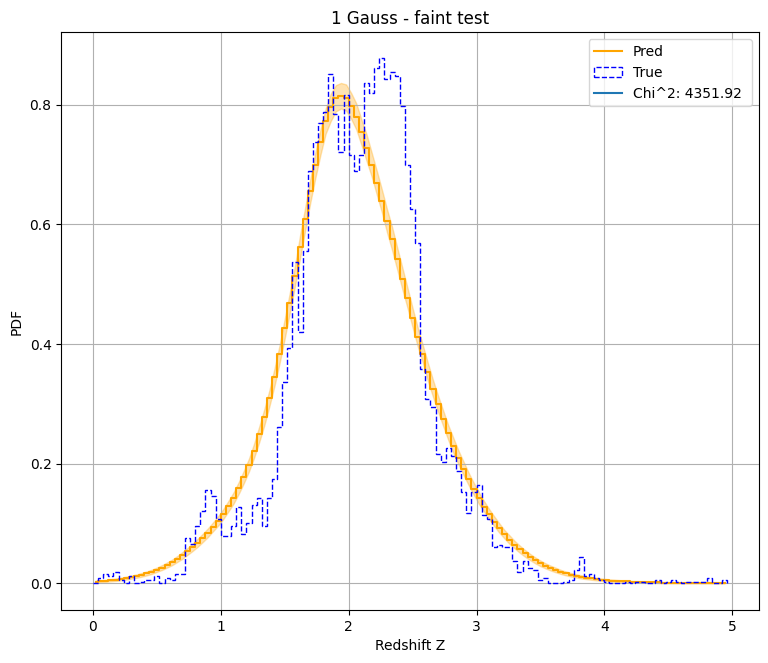

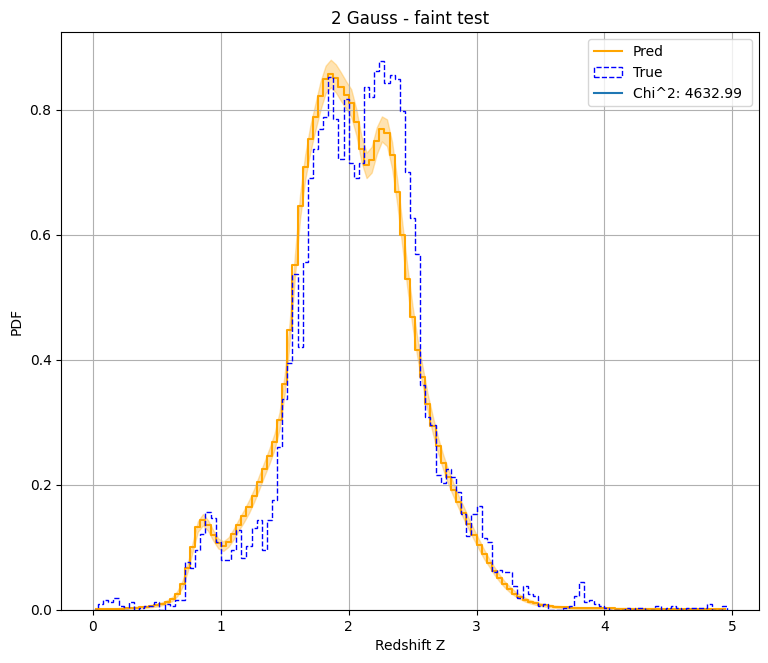

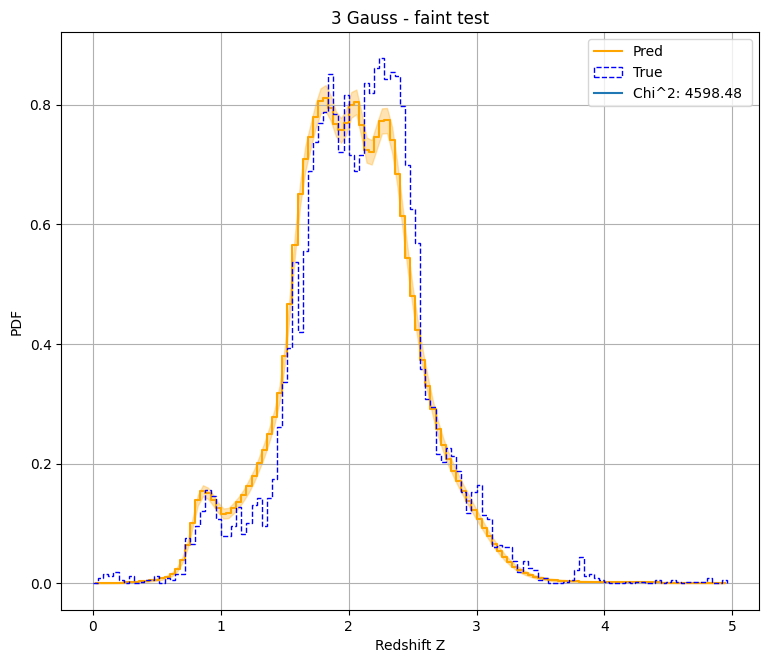

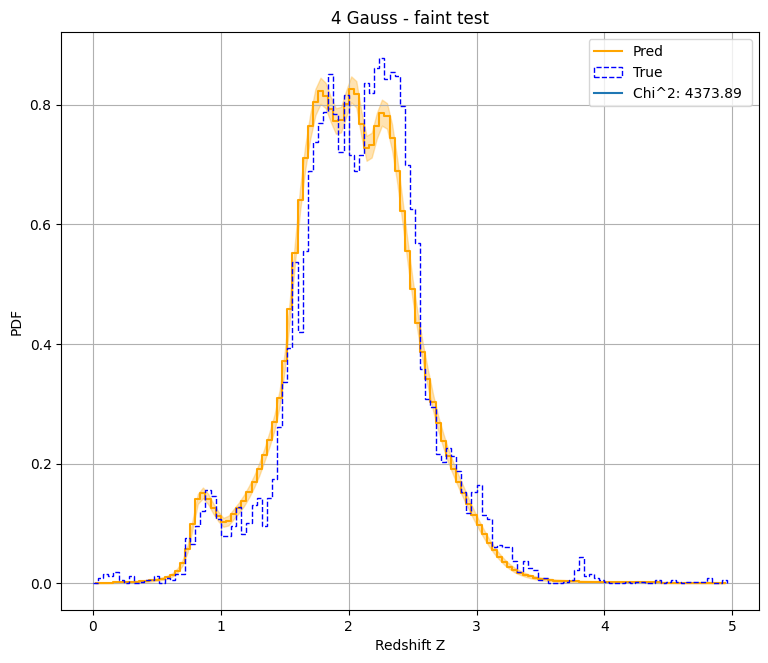

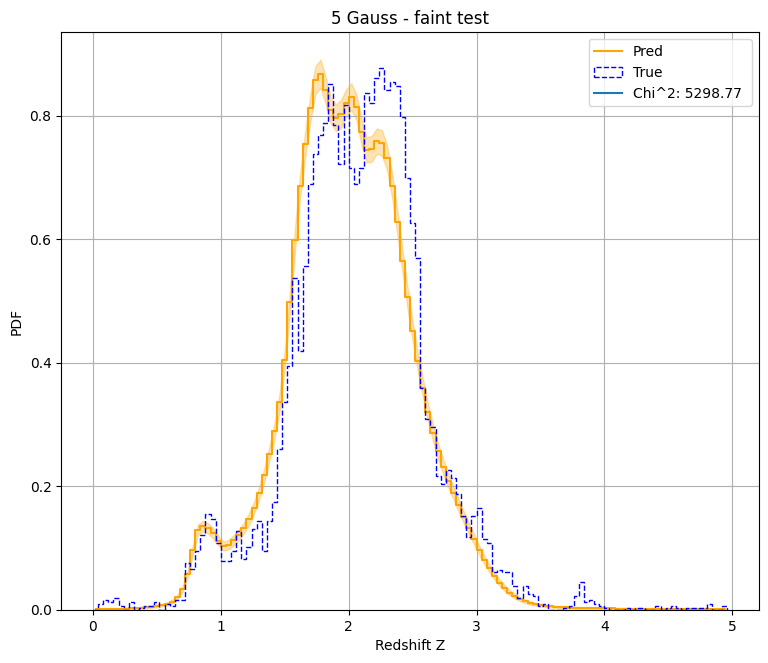

In [11]:
hist, _ = np.histogram(y_faint, bins=bins, density=True)

i = 1
for hist_mean, hist_lower, hist_upper, hist_stddev in zip(hist_means, hist_lowers, hist_uppers, hist_stddevs):

    diff = (hist - hist_mean).reshape(-1,1)
    cov = np.diag(hist_stddev ** 2)
    cov_inv = np.linalg.inv(cov)
    chi_sqr = np.matmul(diff.T ,np.matmul(cov_inv, diff))
    
    plt.figure(figsize=(9,7.5))
    plt.plot(bin_centers, hist_mean, drawstyle='steps-mid',  color="orange", label=f'Pred')
    plt.fill_between(bin_centers, hist_lower, hist_upper, color="orange", alpha=0.3)
    plt.hist(y_faint, bins=np.arange(0,5,0.04), histtype="step", density=True, color="blue", linestyle="--",label="True")
    plt.plot(0,0, color=None, label=f"Chi^2: {float(chi_sqr):.2f} ")
    plt.xlabel('Redshift Z')
    plt.ylabel('PDF')
    plt.title(f'{i} Gauss - faint test')
    plt.legend()
    plt.grid(True)
    plt.show()

    i += 1

In [27]:
## TESTING

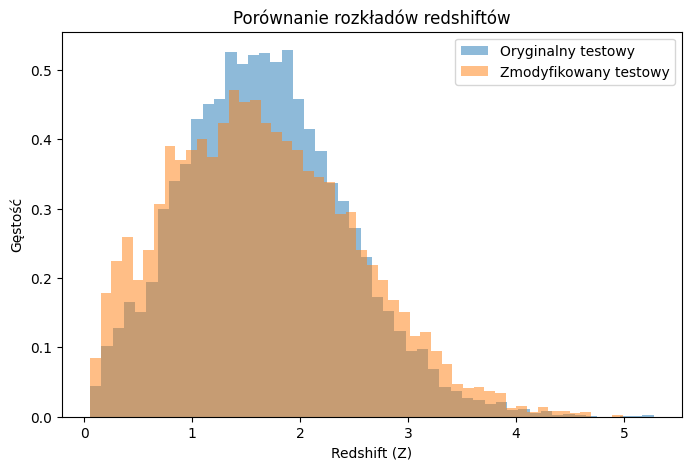

/home/kdrabicki/anaconda3/envs/cpu_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [70]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde, norm
from scipy.stats import lognorm, norm, gamma
import matplotlib.pyplot as plt

filePath = "../../KiDS-DR5-WCScut_x_DESI-DR1-small.fits"

df = data_frame.DataFrame(filePath, "QSO", data_frame.MaxFiller())
X_train, y_train = df.get_train_dataset()
X_test, y_test = df.get_random_test_dataset()
X_faint, y_faint = df.get_faint_test_dataset()

# Dodaj kolumnę Z z redshiftem do df testowego (żeby łatwiej manipulować)
X_test_df = X_test.copy()
X_test_df["Z"] = y_test

# --- Definiujemy empiryczną gęstość rozkładu redshiftu w teście ---
kde = gaussian_kde(y_test)
p_emp = kde(y_test)

# --- Definiujemy docelową dystrybucję p* ---
# Przykład: mieszanka dwóch Gaussów — możesz podmienić na inną funkcję
def p_star(z):
    # parametr lognorm
    s = 0.5  # shape
    scale = np.exp(-0.3)  # exp(mu)
    lognorm_part = 0.6 * lognorm.pdf(z, s=s, scale=scale)

    norm_part = 1 * norm.pdf(z, loc=1.5, scale=1)

    # gamma o kształcie 2 i skali 0.2, przesunięty na lewo (low-z)
    gamma_part = 0.1 * gamma.pdf(z + 0.1, a=2, scale=0.2)  # przesunięcie +0.1 żeby uniknąć ujemnych argumentów

    # suma (ważona mieszanka)
    return norm_part

p_star_vals = p_star(y_test)

# --- Obliczamy wagi ---
w = p_star_vals / p_emp
w = np.clip(w, a_min=0, a_max=np.percentile(w, 99))  # zabezpieczenie przed ekstremalnymi wagami
w_norm = w / np.sum(w)

# --- Losujemy indeksy nowych próbek (ze zwracaniem) ---
N_samples = len(y_test)  # można zmienić na inną liczbę, np. większą lub mniejszą
indices = np.random.choice(len(y_test), size=N_samples, replace=True, p=w_norm)

# --- Tworzymy nowy DataFrame z próbkami zgodnie z wagami ---
resampled_df = X_test_df.iloc[indices].reset_index(drop=True)

# --- Wizualizacja: oryginalny i nowy rozkład redshiftu ---
plt.figure(figsize=(8,5))
plt.hist(y_test, bins=50, density=True, alpha=0.5, label="Oryginalny testowy")
plt.hist(resampled_df["Z"], bins=50, density=True, alpha=0.5, label="Zmodyfikowany testowy")
plt.legend()
plt.xlabel("Redshift (Z)")
plt.ylabel("Gęstość")
plt.title("Porównanie rozkładów redshiftów")
plt.show()

# --- Rozdzielamy cechy i target ---
y_test_modified = resampled_df["Z"].values
X_test_modified = resampled_df.drop(columns=["Z"]).values

# --- Skalowanie cech ---
scaler = StandardScaler()
scaler.fit(X_train)  # fit na treningu

X_test_scaled = scaler.transform(X_test_modified)
X_faint_scaled = scaler.transform(X_faint)

# --- Ustawiamy zmodyfikowane testowe zbiory ---
X_test = X_test_scaled
y_test = y_test_modified


df = data_frame.DataFrame(filePath, "QSO", data_frame.MaxFiller())

In [71]:
hist_means = []
hist_lowers = []
hist_uppers = []
hist_stddevs = []

for n in range(3,4):
    config = {"num_components": n}
    
    all_models = []
    for i in range(1, 6):
        model_path = f"../../models/experiment2/MG_{config["num_components"]}_components_{i}/variables/variables"
        model = models.MLModelContext(strategy=models.MixtureGaussian(df, config)).strategy.network
        model.load_weights(model_path).expect_partial()
        all_models.append(model)

    distributions = []
    for model in all_models:
        distributions.append(model(X_test))
    
    n_samples = 1
    
    bins = np.arange(0, 5, 0.04)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    n_bootstrap = 1000
    bootstrap_histograms = []
    
    rng = np.random.default_rng(seed=1)
    
    for _ in range(n_bootstrap):
        samples = []
        for dist in distributions:
            samples.append(dist.sample(n_samples).numpy().reshape(-1,n_samples))
        samples = np.concatenate(samples)
        
        resampled = rng.choice(samples, size=samples.shape[0], replace=True)
    
        hist, _ = np.histogram(samples.reshape(-1), bins=bins, density=True)
        bootstrap_histograms.append(hist)
    
    bootstrap_histograms = np.array(bootstrap_histograms)

    mean = np.mean(bootstrap_histograms, axis=0)
    std  = np.std(bootstrap_histograms, axis=0)
    
    hist_means.append(mean)
    hist_lowers.append(mean - std)
    hist_uppers.append(mean + std)
    hist_stddevs.append(std)
    
    # hist_means.append(np.mean(bootstrap_histograms, axis=0))
    # hist_lowers.append(np.percentile(bootstrap_histograms, 15.9, axis=0))
    # hist_uppers.append(np.percentile(bootstrap_histograms, 84.1, axis=0))
    # hist_stddevs.append(np.std(bootstrap_histograms, axis=0))

/tmp/ipykernel_249327/3641460330.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.plot(0,0, color=None, label=f"Chi^2: {float(chi_sqr):.2f} ")


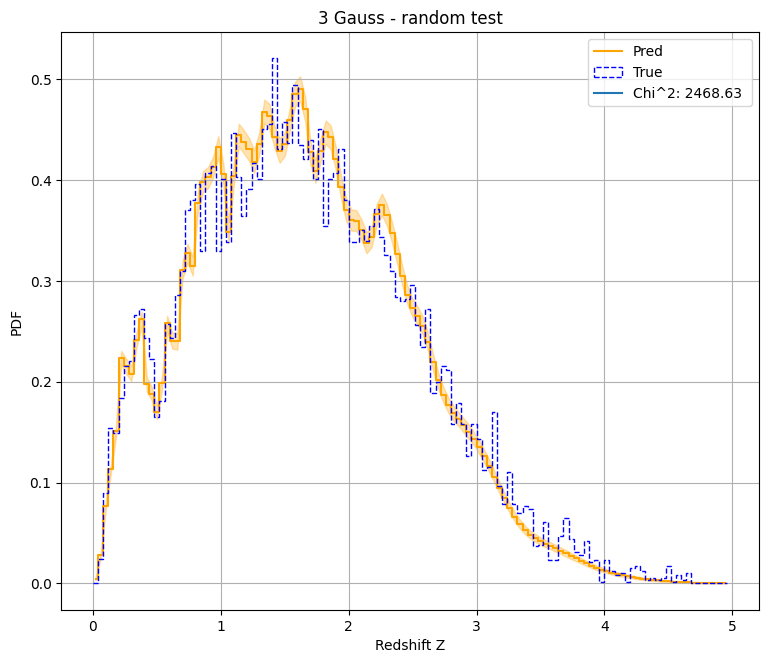

In [72]:
hist, _ = np.histogram(y_test, bins=bins, density=True)


for hist_mean, hist_lower, hist_upper, hist_stddev in zip(hist_means, hist_lowers, hist_uppers, hist_stddevs):

    diff = (hist - hist_mean).reshape(-1,1)
    cov = np.diag(hist_stddev ** 2)
    cov_inv = np.linalg.inv(cov)
    chi_sqr = np.matmul(diff.T ,np.matmul(cov_inv, diff))
    
    plt.figure(figsize=(9,7.5))
    plt.plot(bin_centers, hist_mean, drawstyle='steps-mid',  color="orange", label=f'Pred')
    plt.fill_between(bin_centers, hist_lower, hist_upper, color="orange", alpha=0.3)
    plt.hist(y_test, bins=np.arange(0,5,0.04), histtype="step", density=True, color="blue", linestyle="--",label="True")
    plt.plot(0,0, color=None, label=f"Chi^2: {float(chi_sqr):.2f} ")
    plt.xlabel('Redshift Z')
    plt.ylabel('PDF')
    plt.title(f'{3} Gauss - random test')
    plt.legend()
    plt.grid(True)
    plt.show()

446/446 [==============================] - 0s 349us/step


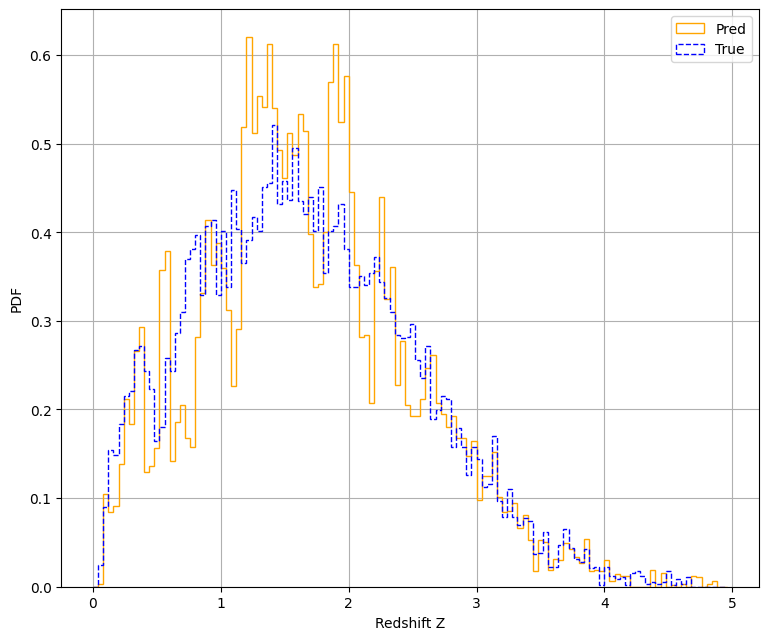

In [73]:
model_path = f"../../models/experiment2/ANN_1/variables/variables"
model = models.MLModelContext(strategy=models.ANNRegressor(df, config)).strategy.network
model.load_weights(model_path).expect_partial()

y_pred = model.predict(X_test)
plt.figure(figsize=(9,7.5))
plt.hist(y_pred, bins=np.arange(0,5,0.04), histtype="step", density=True, label="Pred", color="orange")
plt.hist(y_test, bins=np.arange(0,5,0.04), histtype="step", density=True, label="True", linestyle="--", color="blue")
plt.grid(True)
plt.xlabel('Redshift Z')
plt.ylabel('PDF')
plt.legend()
plt.show()

In [3]:
filePath = "../../KiDS-DR5-WCScut_x_DESI-DR1-small.fits"

df = data_frame.DataFrame(filePath, "QSO", data_frame.MaxFiller())

In [6]:
df.data["has_missing"].sum()

np.int64(13677)

In [13]:
df.data.groupby(df.data["split"]).count()

,ID,RAJ2000,DECJ2000,MAG_GAAP_u,MAGERR_GAAP_u,MAG_GAAP_g,MAGERR_GAAP_g,MAG_GAAP_r,MAGERR_GAAP_r,MAG_GAAP_i1,...,Z-H,Z-Ks,Y-J,Y-H,Y-Ks,J-H,J-Ks,H-Ks,Z_pred,Z_pred_std
split,,,,,,,,,,,,,,,,,,,,,
test,22165,22165,22165,22165,22165,22165,22165,22165,22165,22165,...,22165,22165,22165,22165,22165,22165,22165,22165,22165,22165
train,113763,113763,113763,113763,113763,113763,113763,113763,113763,113763,...,113763,113763,113763,113763,113763,113763,113763,113763,113763,113763
val,21921,21921,21921,21921,21921,21921,21921,21921,21921,21921,...,21921,21921,21921,21921,21921,21921,21921,21921,21921,21921
